# Person - analysis and feature engineering

## Feature encoding

It is necessary to encode certain features before the Machine Learning algorithms can be applied.

### Numerical features

Numerical features can be either directly fed into the Machine Learning algorithm, or they can be bucketed into categories based on the domain knowledge. We will use both approaches below.

### Categorical features:

Due to the fact that most of the ML algorithms can not deal with categorical features (like day of week or weather summary), they need to be somehow encoded as numbers. Below are the most common approaches currently used in the industry:

- for nominal encoding (when order does not matter)
    - one hot encoding
    - one hot encoding with many categories
    - mean encoding
- for ordinal encoding (when order matters)
    - label encoding
    - target guided ordinal encoding

In [2]:
# import ConfigImports Notebook to import and configure libs
%run ../ConfigImports.ipynb

### Load dataset

In [3]:
object_detections = pd.read_csv('../Datasets/Person_no_outliers__2019-09-09_2020-03-02.csv')
print(object_detections.shape)
object_detections.head(2)

(4140, 3)


,date,hour,obs_count_corr
0,2019-09-09,7,2
1,2019-09-09,8,3


### Discuss approach

Even though the dataset above looks very simple, we can not forget how difficult it was to collect it and prepare for further processing.

Based on the date column alone we can extract some interesting features, like:
- month
- week number
- is it a weekend day

Then the idea is to connect it with the weather data extracted from the Dark Sky API.

Once all the features are prepared, we can save the dataset again and move on to another Notebook, where we will create a prediction model, which will predict an object count for a given date and weather situation.

In [4]:
# add date-time related features
object_detections['date'] = pd.to_datetime(object_detections['date'])
object_detections['n_month'] = object_detections['date'].dt.month
object_detections['n_week_in_month'] = (object_detections['date'].dt.day-1)//7+1
object_detections['day_of_week'] = object_detections['date'].dt.dayofweek
object_detections['day_of_week_name'] = object_detections['date'].dt.weekday_name
object_detections['is_weekend_day'] = ((object_detections['date'].dt.dayofweek) // 5 == 1).astype(int)
object_detections.head(2)

,date,hour,obs_count_corr,n_month,n_week_in_month,day_of_week,day_of_week_name,is_weekend_day
0,2019-09-09,7,2,9,2,0,Monday,0
1,2019-09-09,8,3,9,2,0,Monday,0


In [5]:
# load weather data
weather = pd.read_csv('../Datasets/dark_sky_data_2019-09-09_2020-03-02.csv')
weather.head(2)

,ts,dt,cur__summary,cur__precipIntensity,cur__precipProbability,cur__precipType,cur__temperature,cur__apparentTemperature,cur__humidity,cur__windSpeed,cur__windGust,cur__windBearing,cur__cloudCover,cur__uvIndex,cur__visibility,daily__summary,daily__sunriseTime,daily__sunsetTime,daily__temperatureHigh,daily__temperatureLow
0,1567985400,2019-09-09 00:30:00,Possible Light Rain,0.7929,0.47,rain,14.06,14.08,0.96,21.30,35.13,241,0.99,0,10.796,Possible drizzle in the morning.,1568008740,1568055900,16.6,7.01
1,1567989000,2019-09-09 01:30:00,Possible Light Rain,0.8310,0.45,rain,13.99,13.99,0.93,22.49,35.87,215,0.96,0,10.945,Possible drizzle in the morning.,1568008740,1568055900,16.6,7.01


In [6]:
# add date-time related features, so we can merge the datasets together
weather['dt'] = pd.to_datetime(weather['dt'])
weather['date'] = weather['dt'].dt.date
weather['date'] = pd.to_datetime(weather['date'])
weather['hour'] = weather['dt'].dt.hour

check_cols = ['dt', 'date', 'hour']
weather[check_cols].head(2)

,dt,date,hour
0,2019-09-09 00:30:00,2019-09-09,0
1,2019-09-09 01:30:00,2019-09-09,1


In [7]:
# join detections and weather data
merged = object_detections.merge(weather, on=['date', 'hour'])

In [8]:
# make sure that we have not lost any observations
assert object_detections.shape[0] == merged.shape[0]

### Feature analysis & engineering

- *is_weekend_day*

We can see in the plot below that during the weekend hours, people tend to sleep longer.

Then the activity becomes much more visible during the latest hours and it eventually sunsets at around 7PM on average.

The difference observed below proves that *is_weekend_day* should be considered as a good feature in the modelling stage.

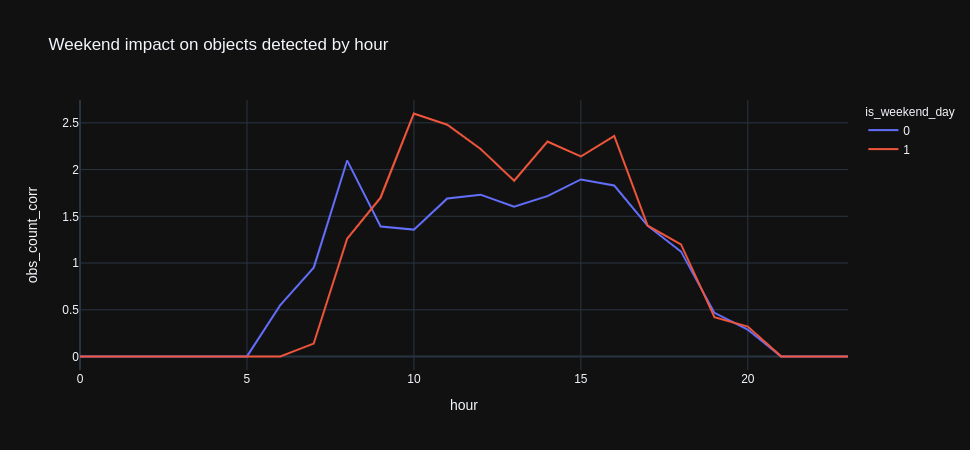

In [9]:
grouped = merged.groupby(['hour', 'is_weekend_day'])['obs_count_corr'].mean().reset_index()
px.line(grouped, y="obs_count_corr", x='hour', color="is_weekend_day",
             title='Weekend impact on objects detected by hour')

- *cur__summary*

Does bad weather have an impact on the number of objects?

In [10]:
# define 3 categories of weather: Good, Bad and Perfect
merged['cur_weather_type'] = 'Good'
bad_weather_words = ['drizzle', 'rain', 'danger']
bad_idx = merged['cur__summary'].str.contains("|".join(bad_weather_words), case=False)
merged.loc[bad_idx, 'cur_weather_type'] = 'Bad'

As can be seen in the plot below, when weather is bad - the number of observations is the lowest.

Then, during a good weather, there is a visible increase in the activity.

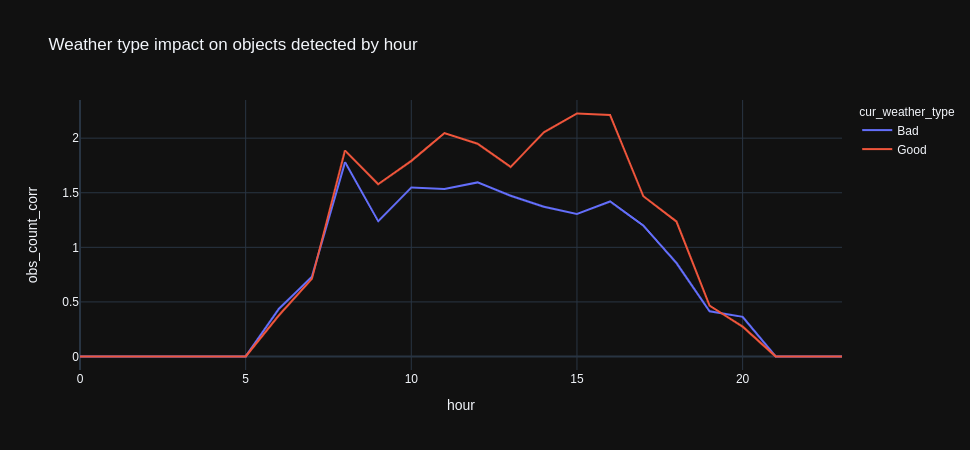

In [11]:
grouped = merged.groupby(['hour', 'cur_weather_type'])['obs_count_corr'].mean().reset_index()
px.line(grouped, y="obs_count_corr", x='hour', color="cur_weather_type",
             title='Weather type impact on objects detected by hour')

- *cur__windGust*

Does gust speed affect the number of objects detected in the hourly time intervals?

Firstly we can plot the trend of gusts over time, and based on that we can decide on the threshold to break it down into categories, like Low and Strong.

Then we can see that for most of the time, Strong wind means less activity.

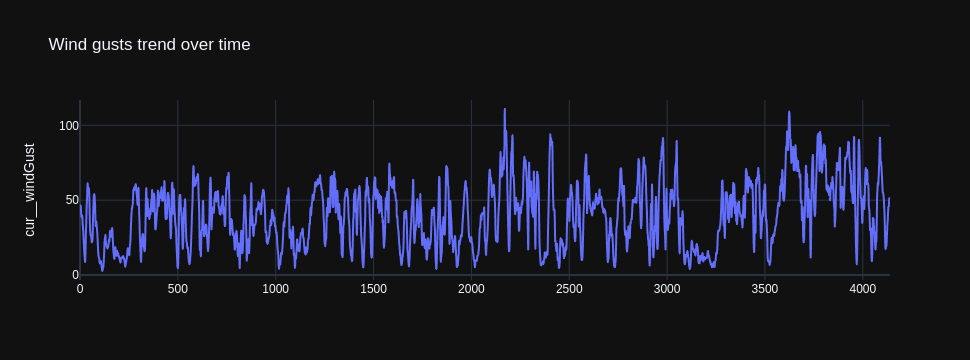

In [12]:
# take a look at the overall wind gust trend
grouped = merged.groupby(['date', 'hour'])['cur__windGust'].mean()
px.line(grouped, y="cur__windGust", height=300,
        title='Wind gusts trend over time')

In [13]:
# define 2 categories of gusts: Normal and Strong
merged['wind_strength'] = 'Low'
idx = merged['cur__windGust'] >= 80
merged.loc[idx, 'wind_strength'] = 'Strong'

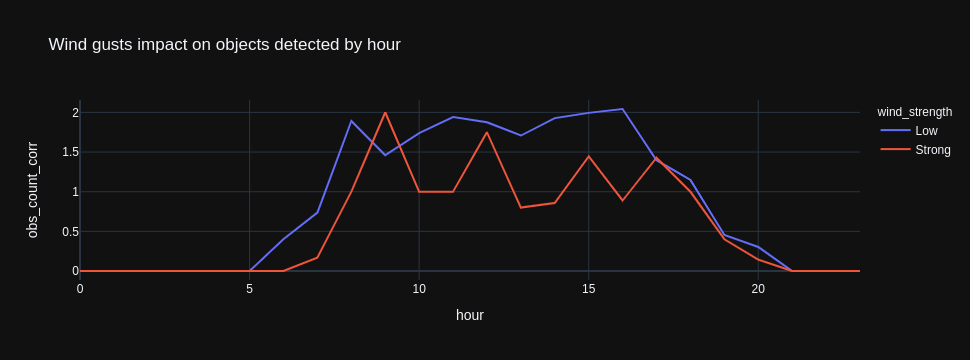

In [14]:
grouped = merged.groupby(['hour', 'wind_strength'])['obs_count_corr'].mean().reset_index()
px.line(grouped, y="obs_count_corr", x='hour', color="wind_strength", height=300,
        title='Wind gusts impact on objects detected by hour')

- *cur__precipIntensity*

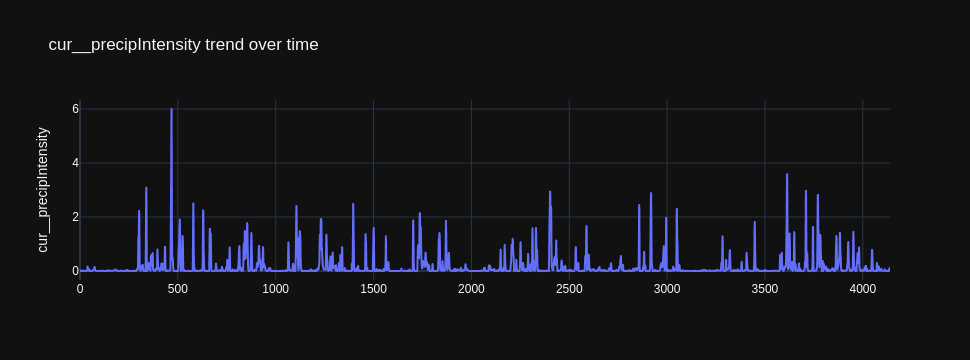

In [15]:
# take a look at the overall trend
grouped = merged.groupby(['date', 'hour'])['cur__precipIntensity'].mean()
px.line(grouped, y="cur__precipIntensity", height=300,
        title='cur__precipIntensity trend over time')

Looking at the rend we can see that there are rare events when precipitation is very high.

Breaking it down into 3 buckets confirms that it influences the count of observations.

In [16]:
# define 2 categories of gusts: Normal and Strong
merged['rain_strength'] = 'Low'
idx = merged['cur__precipIntensity'] > 0.2
merged.loc[idx, 'rain_strength'] = 'Higher'
idx = merged['cur__precipIntensity'] > 1.5
merged.loc[idx, 'rain_strength'] = 'VeryHigh'

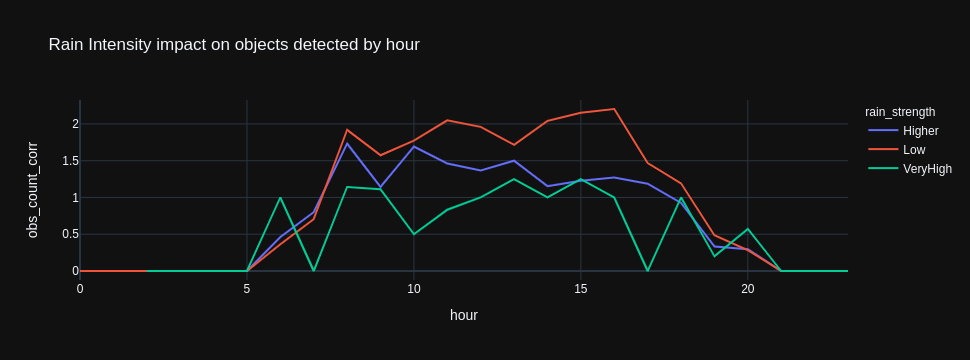

In [17]:
grouped = merged.groupby(['hour', 'rain_strength'])['obs_count_corr'].mean().reset_index()
px.line(grouped, y="obs_count_corr", x='hour', color="rain_strength", height=300,
        title='Rain Intensity impact on objects detected by hour')

Next, we can add all numerical columns as a separate dataframe

In [18]:
num_feat = ['is_weekend_day', 'cur__precipIntensity', 'cur__windSpeed', 'cur__windGust', 'cur__cloudCover',
           'cur__apparentTemperature', 'cur__precipProbability']
numerical = merged[num_feat]

### Encode categorical features

Features `cur_weather_type`, `gust_strength` and `day_of_week_name` can be treated as nominal for now, and we can encode them using one-hot-encoding technique.

One-hot-encoding takes all values from a feature and turns them into individual columns. A good practice here is to always drop one of the columns, as it can be derived based on other columns.

In [266]:
# One hot encode nominal categorical variables
nom_cat_features = ['cur_weather_type', 'wind_strength', 'rain_strength', 'day_of_week_name']
dummies = pd.get_dummies(merged[nom_cat_features], drop_first=True)

dummies.head(2)

,cur_weather_type_Good,wind_strength_Strong,rain_strength_Low,rain_strength_VeryHigh,day_of_week_name_Monday,day_of_week_name_Saturday,day_of_week_name_Sunday,day_of_week_name_Thursday,day_of_week_name_Tuesday,day_of_week_name_Wednesday
0,1,0,1,0,1,0,0,0,0,0
1,1,0,1,0,1,0,0,0,0,0


### Cyclical features

How do we deal with features, like: `hour` or `week_number`? Even though they are numerical, they are not a typical numerical, ordinal values and they basically cycle through the time axis.

See this [Kaggle link](https://www.kaggle.com/avanwyk/encoding-cyclical-features-for-deep-learning) for more about this.

In [267]:
def encode_cyclical(df, col, max_val):
    df[col + '_sin'] = np.sin(2 * np.pi * df[col]/max_val)
    df[col + '_cos'] = np.cos(2 * np.pi * df[col]/max_val)    

cycl_feat = ['hour', 'n_week_in_month', 'n_month']
cyclical = merged[cycl_feat].copy()
for col in cycl_feat:
    encode_cyclical(cyclical, col, cyclical[col].max())
    cyclical = cyclical.drop(columns=[col])

In [268]:
cyclical.head(2)

,hour_sin,hour_cos,n_week_in_month_sin,n_week_in_month_cos,n_month_sin,n_month_cos
0,0.942261,-0.33488,0.587785,-0.809017,-1.0,-1.836970e-16
1,0.816970,-0.57668,0.587785,-0.809017,-1.0,-1.836970e-16


### Output (target_ variable)

In [269]:
y = merged['obs_count_corr']

### Encode all selected features

Now, instead of merging all features inside a single dataframe, we can keep them as a tuple of individual dataframes and pickle that data structure.

This will make it easier to pick and choose features in the forecasting Notebook

In [270]:
ret_struct = ((numerical, dummies, cyclical, merged), y)
filename = 'Person_features__2019-09-09_2020-03-02.pickle'
outfile = open(f'../Datasets/{filename}','wb')
pickle.dump(ret_struct, outfile)
outfile.close()